# Spatial Interaction Model 

The methodology of this exercise follows that of pysal documentation: http://dx.doi.org/10.18335/region.v3i2.175. The package has since evolved and continuously improved, including the structure of its modules, but the key methods remain the same.

Pysal presents four types of Spatial Interaction Models from Wilson (1971), namely:
1. Unconstrained
2. Production-constrained
3. Attraction-constrained 
4. Doubly-constrained 

In addition to a global model, pysal allows you to build local models that are calibrated at individual origins/destinations. 

Here I apply a global model on bus OD data in Singapore. The bus OD data is a small subset of bus trip data available via LTA Data Mall: https://datamall.lta.gov.sg/content/datamall/en.html. Preprocessing has been performed by matching O/D to bus stop locations, and line features connecting each pair of OD are created. Weight column carries the expected volume of passengers on the pair of OD nodes.


## Global Model

In [6]:
import geopandas as gpd 
import networkx as nx 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os, sys 


In [13]:
from shapely import speedups
speedups.disable()

In [14]:
# import line shapefile (representing OD flows between each pair of bus stops)
orig_flow = gpd.read_file(r"data\SampleODFlow.shp")
orig_flow.head()

,ORIG_FID,COL_A,Source,Target,Weight,StartX,StartY,EndX,EndY,Shape_Leng,geometry
0,1,0,84041,84289,10,39288.1721,34105.0533,39893.8384,34310.9184,639.696886,"LINESTRING (39288.172 34105.053, 39893.838 343..."
1,2,1,84041,85061,41,39288.1721,34105.0533,40686.3860,34863.1034,1590.484852,"LINESTRING (39288.172 34105.053, 39987.279 344..."
2,3,2,84041,94009,1,39288.1721,34105.0533,41277.2327,33338.1144,2131.796741,"LINESTRING (39288.172 34105.053, 39951.192 338..."
3,4,3,84041,99021,4,39288.1721,34105.0533,44238.0324,40962.9509,8457.651948,"LINESTRING (39288.172 34105.053, 39838.157 348..."
4,5,4,84041,99041,1,39288.1721,34105.0533,44940.0411,41083.2140,8979.885854,"LINESTRING (39288.172 34105.053, 39916.158 348..."


In [15]:
orig_flow.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 173237 entries, 0 to 173236
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ORIG_FID    173237 non-null  int64   
 1   COL_A       173237 non-null  int64   
 2   Source      173237 non-null  int64   
 3   Target      173237 non-null  int64   
 4   Weight      173237 non-null  int64   
 5   StartX      173237 non-null  float64 
 6   StartY      173237 non-null  float64 
 7   EndX        173237 non-null  float64 
 8   EndY        173237 non-null  float64 
 9   Shape_Leng  173237 non-null  float64 
 10  geometry    173237 non-null  geometry
dtypes: float64(5), geometry(1), int64(5)
memory usage: 14.5 MB


<AxesSubplot:>

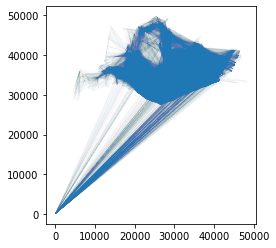

In [6]:
orig_flow.plot(linewidth=0.5, alpha=0.01)

Some of the nodes are in erroneous locations (X/Y of 0,0). We will remove these OD links from the dataset.

In [16]:
# drop any flows that start/end at 0 (error records)
clean_flow = orig_flow[(orig_flow['StartX']!=0) & (orig_flow['StartY']!=0) & (orig_flow['EndX']!=0) & (orig_flow['EndY']!=0)]

In [8]:
clean_flow.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 171013 entries, 0 to 173236
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ORIG_FID    171013 non-null  int64   
 1   COL_A       171013 non-null  int64   
 2   Source      171013 non-null  int64   
 3   Target      171013 non-null  int64   
 4   Weight      171013 non-null  int64   
 5   StartX      171013 non-null  float64 
 6   StartY      171013 non-null  float64 
 7   EndX        171013 non-null  float64 
 8   EndY        171013 non-null  float64 
 9   Shape_Leng  171013 non-null  float64 
 10  geometry    171013 non-null  geometry
dtypes: float64(5), geometry(1), int64(5)
memory usage: 15.7 MB


<AxesSubplot:>

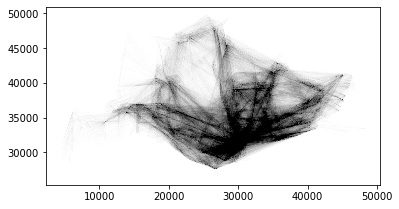

In [9]:
clean_flow.plot(linewidth=0.5, alpha=0.005, color='k')

After removing erroneous OD links, now all the flows are somewhat contained within the national boundary.

In [17]:
# sum the total flow volume by origin/destination
Sum_By_Source = clean_flow.groupby('Source').agg({'Weight': 'sum'})
sum_by_source_dict = Sum_By_Source.to_dict(orient='index')
Sum_By_Target = clean_flow.groupby('Target').agg({'Weight': 'sum'})
sum_by_target_dict = Sum_By_Target.to_dict(orient='index')


In [18]:
# create new dataframe columns to store total flow volume 
clean_flow['TotalOriginFlow'] = clean_flow.apply(lambda x: sum_by_source_dict[x['Source']]['Weight'], axis=1)
clean_flow['TotalDestinationFlow'] = clean_flow.apply(lambda x: sum_by_target_dict[x['Target']]['Weight'], axis=1)

C:\Users\ytxu\AppData\Local\ESRI\conda\envs\thesis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [13]:
clean_flow.head()

,ORIG_FID,COL_A,Source,Target,Weight,StartX,StartY,EndX,EndY,Shape_Leng,geometry,TotalOriginFlow,TotalDestinationFlow
0,1,0,84041,84289,10,39288.1721,34105.0533,39893.8384,34310.9184,639.696886,"LINESTRING (39288.172 34105.053, 39893.838 343...",1501,317
1,2,1,84041,85061,41,39288.1721,34105.0533,40686.3860,34863.1034,1590.484852,"LINESTRING (39288.172 34105.053, 39987.279 344...",1501,922
2,3,2,84041,94009,1,39288.1721,34105.0533,41277.2327,33338.1144,2131.796741,"LINESTRING (39288.172 34105.053, 39951.192 338...",1501,142
3,4,3,84041,99021,4,39288.1721,34105.0533,44238.0324,40962.9509,8457.651948,"LINESTRING (39288.172 34105.053, 39838.157 348...",1501,257
4,5,4,84041,99041,1,39288.1721,34105.0533,44940.0411,41083.2140,8979.885854,"LINESTRING (39288.172 34105.053, 39916.158 348...",1501,383


In [19]:
# create the pandas series for flows, Oi (total origin flows), Dj (total destination flows), Dij (flow between each pair of OD), Origin (origin nodes), Destination (destination nodes)
flows = clean_flow['Weight'].values
Oi = clean_flow['TotalOriginFlow'].values
Dj = clean_flow['TotalDestinationFlow'].values 
Dij = clean_flow['Weight'].values
Origin = clean_flow['Source'].values
Destination = clean_flow['Target'].values

In [1]:
import pysal

In [2]:
# improt four types of the spatial interaction model
from pysal.model.spint import Gravity
from pysal.model.spint import Attraction
from pysal.model.spint import Doubly
from pysal.model.spint import Production


C:\Users\ytxu\AppData\Local\ESRI\conda\envs\thesis\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.4.3-CAPI-1.8.3 r4285) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [105]:
help(Gravity) # get some information on how to use the model

Help on class Gravity in module spint.gravity:

class Gravity(BaseGravity)
 |  Gravity(flows, o_vars, d_vars, cost, cost_func, constant=True, framework='GLM', SF=None, CD=None, Lag=None, Quasi=False)
 |  
 |  Unconstrained (traditional gravity) gravity-type spatial interaction model
 |  
 |  Parameters
 |  ----------
 |  flows           : array of integers
 |                    n x 1; observed flows between O origins and D destinations
 |  cost            : array
 |                    n x 1; cost to overcome separation between each origin and
 |                    destination associated with a flow; typically distance or time
 |  cost_func       : string or function that has scalar input and output
 |                    functional form of the cost function;
 |                    'exp' | 'pow' | custom function
 |  o_vars          : array (optional)
 |                    n x p; p attributes for each origin of  n flows; default
 |                    is None
 |  d_vars          : array (o

In [106]:
# here we use a power function to estimate distnace-decay effect of spatial interaction
# other options available are an exponential function or other customised functions
# other parameters are kept as default
gravity = Gravity(flows, Oi, Dj, Dij, 'pow')

C:\Users\ytxu\AppData\Local\ESRI\conda\envs\thesis\lib\site-packages\spglm\family.py:288: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


In [21]:
# print out model parameters: k-estimated beta coefficients
gravity.params

array([-2.35307396e+00,  3.63203087e-01,  3.70110196e-01,  2.13238133e-03])

In [107]:
production = Production(flows, Origin, Dj, Dij, 'pow')

In [23]:
production.params

array([-0.15433659, -0.31876046,  0.85198099, ..., -1.20166076,
        0.28722615,  0.00372292])

In [108]:
attraction = Attraction(flows, Destination, Oi, Dij, 'pow')

In [25]:
attraction.params

array([ 0.2535089 , -0.43212538, -0.33179428, ...,  2.08131933,
        0.31036125,  0.00302471])

In [109]:
doubly = Doubly(flows, Origin, Destination, Dij, 'pow')
doubly.params[-1:]

array([1.])

In [110]:
R2, adjR2, SSI, SRMSE, AIC = [], [], [], [], []
model_name = ['grav', 'prod', 'att', 'doub']
col_names = ['R2', 'adjR2', 'AIC', 'SRMSE', 'SSI']
models = [gravity, production, attraction, doubly]

In [111]:
for model in models:
    R2.append(model.pseudoR2)
    adjR2.append(model.adj_pseudoR2)
    SSI.append(model.SSI)
    SRMSE.append(model.SRMSE)
    AIC.append(model.AIC)

In [112]:
cols = {'model_name': model_name,
'R2': R2,
'adjR2': adjR2,
'SSI': SSI,
'SRMSE': SRMSE,
'AIC': AIC }

In [113]:
data = pd.DataFrame(cols).set_index('model_name')
data[col_names]

,R2,adjR2,AIC,SRMSE,SSI
model_name,,,,,
grav,0.936174,0.936173,601212.511991,2.150315e-12,1.000000
prod,0.936174,0.935157,610782.560038,4.609112e-05,0.999960
att,0.936174,0.935155,610800.564345,4.800790e-05,0.999958
doub,0.936174,0.934139,620370.511993,2.137997e-07,1.000000


In [35]:
print('SRMSE for exp distance-decay: ', doubly.SRMSE)
pow_doubly = Doubly(flows, Origin, Destination, Dij, 'pow')
print('SRMSE for exp distance-decay: ', pow_doubly.SRMSE)

SRMSE for exp distance-decay:  4.243571681363784
C:\Users\ytxu\AppData\Local\ESRI\conda\envs\thesis\lib\site-packages\spglm\family.py:288: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)
SRMSE for exp distance-decay:  2.1379775972868026e-07


We can tell from the above that a global model performs rather poorly, with the doubly constraint model (best-performing) giving only R-squared value of 0.65. The power distance-decay specification results in a better model fit.

In [59]:
clean_flow.head()

,ORIG_FID,COL_A,Source,Target,Weight,StartX,StartY,EndX,EndY,Shape_Leng,geometry,TotalOriginFlow,TotalDestinationFlow
0,1,0,84041,84289,10,39288.1721,34105.0533,39893.8384,34310.9184,639.696886,"LINESTRING (39288.172 34105.053, 39893.838 343...",1501,317
1,2,1,84041,85061,41,39288.1721,34105.0533,40686.3860,34863.1034,1590.484852,"LINESTRING (39288.172 34105.053, 39987.279 344...",1501,922
2,3,2,84041,94009,1,39288.1721,34105.0533,41277.2327,33338.1144,2131.796741,"LINESTRING (39288.172 34105.053, 39951.192 338...",1501,142
3,4,3,84041,99021,4,39288.1721,34105.0533,44238.0324,40962.9509,8457.651948,"LINESTRING (39288.172 34105.053, 39838.157 348...",1501,257
4,5,4,84041,99041,1,39288.1721,34105.0533,44940.0411,41083.2140,8979.885854,"LINESTRING (39288.172 34105.053, 39916.158 348...",1501,383


In [62]:
import seaborn as sns

<AxesSubplot:xlabel='Shape_Leng', ylabel='Weight'>

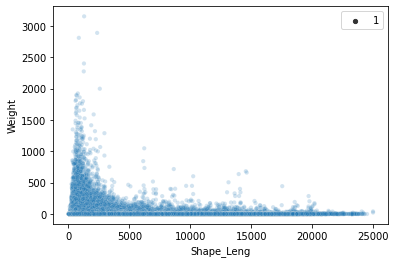

In [66]:
sns.scatterplot(x='Shape_Leng', y='Weight', data=clean_flow, size=1, alpha=0.2)

<AxesSubplot:xlabel='Count', ylabel='Weight'>

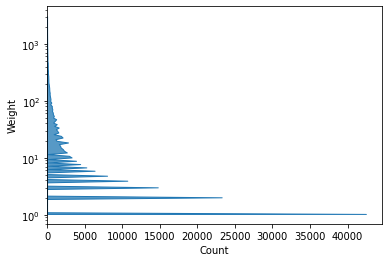

In [90]:
sns.histplot(data=clean_flow, y='Weight',element='poly', log_scale=True)

## Local Model

In [103]:
gravity = Gravity(flows, Oi, Dj, Dij, 'pow')
local_gravity = gravity.local(loc_index=Origin, locs=all_unique_loc)

C:\Users\ytxu\AppData\Local\ESRI\conda\envs\thesis\lib\site-packages\spglm\family.py:288: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


Exception: one or more input arrays have more columns than rows

In [93]:
all_loc = Destination + Origin

In [104]:
all_unique_loc = np.unique(all_loc).reshape(1)

ValueError: cannot reshape array of size 46590 into shape (1,)

In [101]:
all_unique_loc.reshape(-1)

array([  2068,   2078,   2124, ..., 198248, 198332, 198352], dtype=int64)

In [54]:
help(gravity.local)

Help on method local in module spint.gravity:

local(loc_index, locs) method of spint.gravity.Gravity instance
    Calibrate local models for subsets of data from a single location to all
    other locations
    
    Parameters
    ----------
    loc_index   : n x 1 array of either origin or destination id label for
                  flows; must be explicitly provided for local version of
                  basic gravity model since these are not passed to the
                  global model.
    
    locs        : iterable of either origin or destination labels for which
                  to calibrate local models; must also be explicitly
                  provided since local gravity models can be calibrated from origins
                  or destinations. If all origins are also destinations and
                  a local model is desired for each location then use
                  np.unique(loc_index)
    
    Returns
    -------
    results     : dict where keys are names of model ou